In [ ]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd
from time import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import math as m

In [ ]:
tf.random.set_seed(1234)

N = 500
L_ref = 1
L = 1
q = 1000
k =  0.5
n_2 = 25

#r=-1

y_w = 1
#T_inf = 20
y_e = 0

y_ref = 1

epochs = 50000
icount = 5000

x = tf.random.uniform((N,1),0,L,dtype='float64')/L_ref
x_bc_w = tf.ones((1,1),dtype = 'float64')*0.0
x_bc_e = tf.ones((1,1),dtype='float64')*L
x_bc = np.vstack([x_bc_w, x_bc_e])
#x_bc = x_bc_w
#y_bc = tf.ones((1,1),dtype = 'float64')*T_w/T_ref
y_bc = np.vstack([tf.ones((1,1),dtype = 'float64')*y_w/y_ref, tf.ones((1,1),dtype = 'float64')*y_e/y_ref])
print(y_bc)

[[1.]
 [0.]]


In [ ]:
def calculate_loss(y_pred,y_actual):
  return tf.norm(y_actual-y_pred,2)/2.0

In [ ]:
@tf.function
def train_pinn(x):
  with tf.GradientTape(persistent = True) as higher_tape:
    higher_tape.watch(x)
    with tf.GradientTape(persistent=True) as tape:
      tape.watch(x)

      #physics
      y = tf.cast(model(x,training=True),tf.float64)
      dy_dx = tape.gradient(y,x)
      ddy_ddx = tape.gradient(dy_dx,x)
      #s = -1*n_2*(tf.subtract(y,T_inf/T_ref))
      ns_residue = tf.add(-1*ddy_ddx,dy_dx)
      loss_ns = tf.norm(ns_residue,2)/N

      #boundary condition
      y_bc_pred = tf.cast(model(x_bc,training=True),tf.float64)
      loss_bc = calculate_loss(y_bc_pred,y_bc)

      #loss_ns, loss_bc=0
      total_loss = tf.add(loss_ns,loss_bc)
  grads = tape.gradient(total_loss, model.trainable_weights)
  optimizer.apply_gradients(zip(grads, model.trainable_weights))
  return total_loss,loss_ns,loss_bc,ddy_ddx

In [ ]:
nnode = 20
act = 'tanh'


model = tf.keras.Sequential([
    layers.Dense(nnode,input_shape=(1,),activation=act),
    layers.Dense(nnode,activation=act),
    #layers.Dense(nnode,activation=act),
    layers.Dense(1,activation=act)
])

#loss_ns,bc_loss = train_pinn(t)
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000,5000],[1e-2,1e-3,5e-4,1e-4])
optimizer = keras.optimizers.Adam(learning_rate=lr)


In [ ]:
#y_bc = tf.cast(model(tf.ones((1,1),dtype='float64')*0,training=True),tf.float64)
#tf.print(y_bc)

[[0]]


In [ ]:
loss_array = []
print('Epoch    Total loss     NS loss    BC loss')

for epoch in range(epochs):
  total_loss, ns_loss, bc_loss,ddy_ddx = train_pinn(x)
  tl = total_loss.numpy()
  loss_array.append(tl)
  if epoch % icount == 0:
        print('  %d     %.4f       %.4f    %.4f' % (epoch, total_loss, ns_loss, bc_loss))

Epoch    Total loss     NS loss    BC loss


  0     0.5399       0.0182    0.5217
  5000     0.0150       0.0038    0.0112
  10000     0.0119       0.0025    0.0094
  15000     0.0085       0.0012    0.0073
  20000     0.0069       0.0011    0.0058
  25000     0.0056       0.0009    0.0048
  30000     0.0046       0.0006    0.0040
  35000     0.0040       0.0005    0.0035
  40000     0.0036       0.0005    0.0031
  45000     0.0032       0.0005    0.0028


In [ ]:
print(loss_array)

[0.02766195940984264, 0.05591774036850321, 0.02825776991121816, 0.031796074849627834, 0.03707567712681094, 0.033542916869965377, 0.028531037263793118, 0.027477687014717544, 0.030238680681875678, 0.031044053011790845, 0.028851430813458537, 0.026869219665880933, 0.02698777289394795, 0.028255408446605172, 0.028596944922379366, 0.02762395116977879, 0.026607170747211976, 0.02657292642112741, 0.027251148638528774, 0.027609955272790598, 0.02720961722494423, 0.026552395337406554, 0.026267624065097157, 0.02646137696395507, 0.026774311832420787, 0.026830034929217456, 0.0265816919671326, 0.02627844705075037, 0.02617533450364007, 0.02629366565971296, 0.02642458362603499, 0.026365334471114707, 0.026147438733711545, 0.025987666487662337, 0.0260213890690109, 0.026141179991791646, 0.02614118989019864, 0.02599284126629585, 0.025874402184816486, 0.025908387794428046, 0.02598614390438178, 0.025946247532728575, 0.025833252387718993, 0.02581096755112284, 0.025881012979869614, 0.025889135027681903, 0.025805

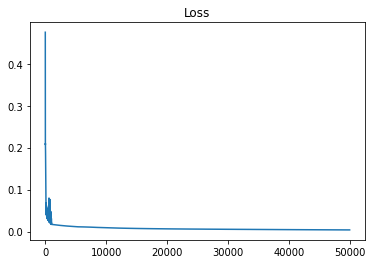

In [ ]:
plt.title("Loss")
plt.plot(loss_array)
#plt.plot(val_loss_array)
plt.show()

In [ ]:
def analytical_sol(w):
  #t=t*-1
  m = tf.subtract(tf.math.exp(w),1.0)
  c = tf.subtract(tf.math.exp(1.0),1.0)
  C = (m/c)*-1
  #(T_w-T_inf)
  y_analytical = tf.add(C,1.0)
  return y_analytical

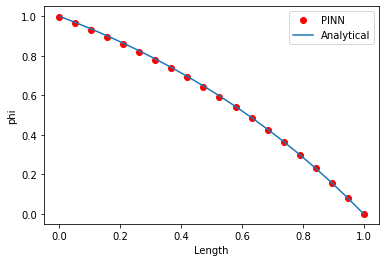

In [ ]:
t_p = np.linspace(0,1,20)
t_p = tf.cast(t_p,tf.float32)
y_pred = model(t_p)

#t_p = np.linspace(0,1,20)*2
y_analytical = analytical_sol(t_p)
plt.plot(t_p,y_pred,'o',label='PINN',c="red")
plt.plot(t_p,y_analytical,label='Analytical')
plt.xlabel("Length")
plt.ylabel("phi")
#print(max(ypred),min(ypred))
plt.legend()

In [ ]:
y_a = tf.reshape(y_analytical,[20,1])

In [ ]:
print(y_a)

tf.Tensor(
[[1.        ]
 [0.96854925]
 [0.9353989 ]
 [0.900457  ]
 [0.86362684]
 [0.82480633]
 [0.7838879 ]
 [0.7407582 ]
 [0.69529766]
 [0.6473805 ]
 [0.59687364]
 [0.54363745]
 [0.48752433]
 [0.42837876]
 [0.36603683]
 [0.300326  ]
 [0.23106396]
 [0.15805906]
 [0.08110869]
 [0.        ]], shape=(20, 1), dtype=float32)


In [ ]:
print((y_pred - y_a)/y_a)

tf.Tensor(
[[-0.00502574]
 [-0.00500721]
 [-0.00500007]
 [-0.00498538]
 [-0.00498079]
 [-0.00497754]
 [-0.00495861]
 [-0.00493697]
 [-0.00492741]
 [-0.00492909]
 [-0.00492986]
 [-0.00492066]
 [-0.00490036]
 [-0.00487477]
 [-0.00485444]
 [-0.00484367]
 [-0.00483154]
 [-0.00479676]
 [-0.00465846]
 [        inf]], shape=(20, 1), dtype=float32)


In [ ]:
print(((y_pred - y_a)*100/y_a))

tf.Tensor(
[[-0.50257444]
 [-0.5007213 ]
 [-0.50000674]
 [-0.49853837]
 [-0.49807948]
 [-0.49775422]
 [-0.4958614 ]
 [-0.49369723]
 [-0.4927408 ]
 [-0.49290863]
 [-0.49298584]
 [-0.49206626]
 [-0.49003577]
 [-0.48747718]
 [-0.485444  ]
 [-0.4843674 ]
 [-0.4831541 ]
 [-0.4796758 ]
 [-0.46584564]
 [        inf]], shape=(20, 1), dtype=float32)


In [ ]:
x_plt = 0.5
x_p = tf.ones((1,1),dtype = 'float32')*x_plt
y_p = tf.cast(model(x_p),tf.float32)*T_ref
print(y_p)


tf.Tensor([[26.389908]], shape=(1, 1), dtype=float32)


In [ ]:
print(ddy_ddx)